<h1><center>Happy Maps from Instagrams</center></h1>

In [2]:
import pyspark
import pandas as pd
import json
import folium
import numpy as np
from pyspark.sql import SQLContext
sqlContext1 = SQLContext(sc)
from IPython.display import Image
import vincent
vincent.core.initialize_notebook()

In [1]:
from IPython.display import Image

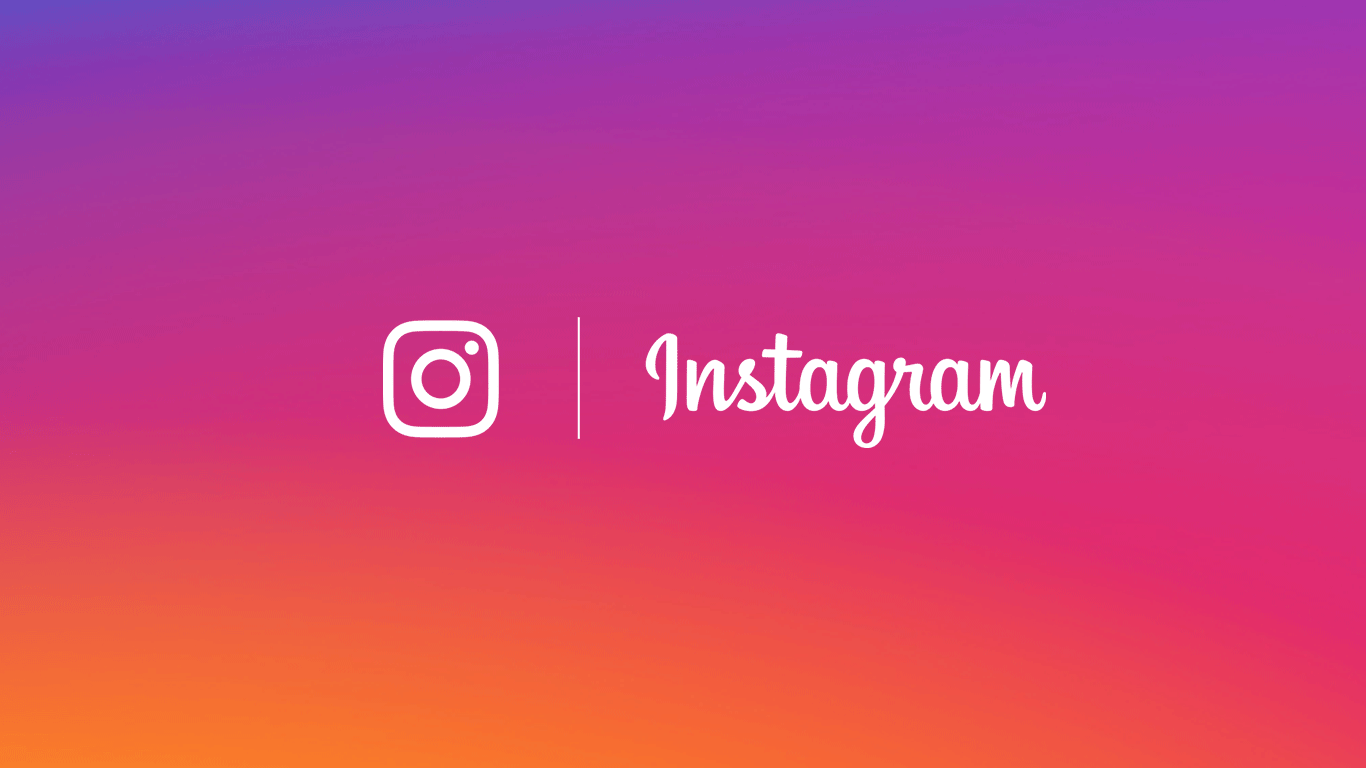

In [47]:
Image('pic/instagram.png', width=850,height=150, retina= True)

In [44]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [5]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In this Notebook, I will give a presentation of the work accomplished during the project of the **Applied Data Analysis** Course supervised by *Michele Catasta* at *EPFL*, the tool used and the final results.


This project was focused on an Instagram dataset coming from a public source, available on the EPFL cluster. The principal goals of the project were:

* use  **machine learning methods** for **sentiment analysis**,
* handle huge datasets with an appropriate language **Spark** and 
* give vizualized results, with **Folium** and **Vincent** and give some interpretations.

## Presentation of the dataset
An example of an instagram is:

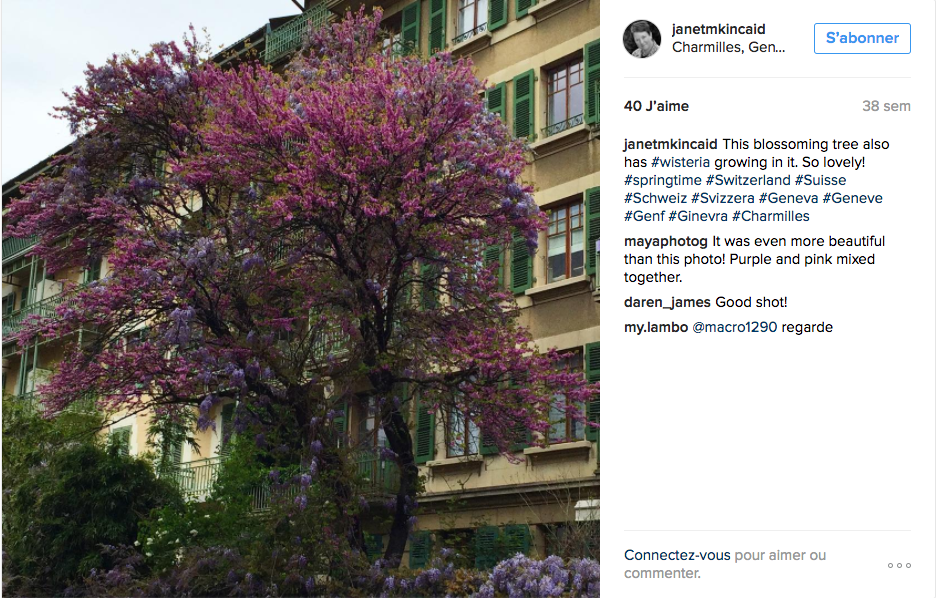

In [4]:
Image('pic/insta_exemple.png', width=650,height=150)

For each instagram, we have as many information as you can see on the above example. There are many *machine learning methods* that can classify images, but this is not the goal of the project, we focus on the the text description of the image.


The text contains:

* main text : `This blossoming tree also has wisteria growing in it. lovely!`
* tags : `#wisteria #springtime #Switzerland #Suisse #Schweiz #Svizzera #Geneva #Geneve #Genf #Ginevra #Charmilles`

Obviously this instagram is considered as happy, we will see how we will determine this later.

For each instagram, we also have the date when it was posted. As you can see below, we have around ten times more data for *january* and *february* and we don't have any instagrams for *november* and *december*. The sentiment analysis result per month will more reliable in the 2 first month of the year, because we have more data ..

#### Distribution of instagrams per month

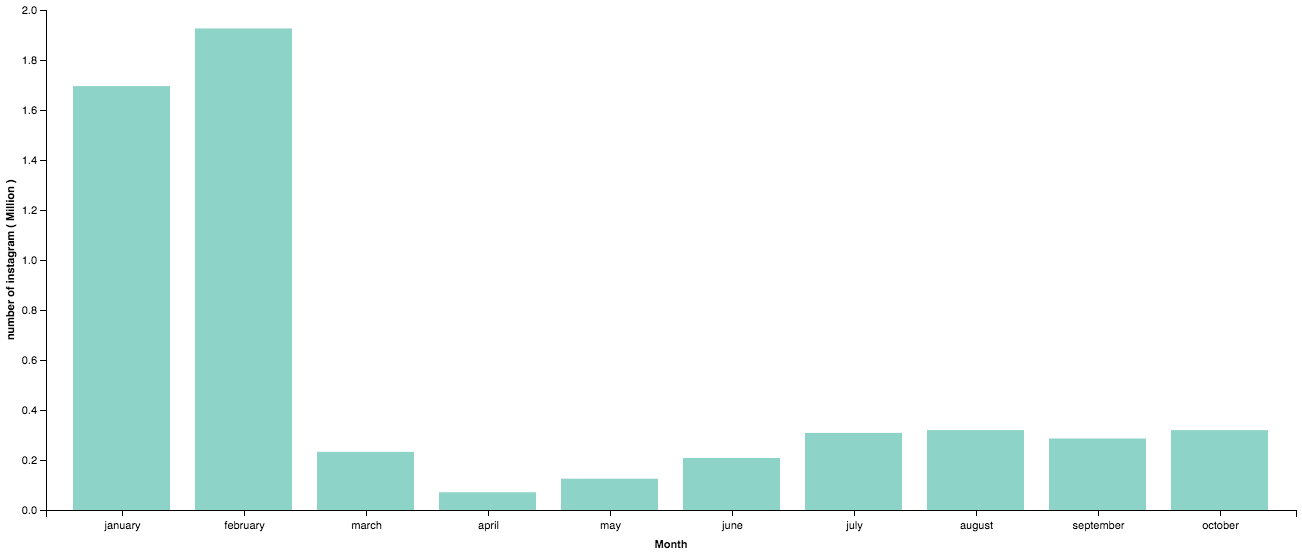

In [13]:
Image('pic/insta_per_month.png', width=1050,height=250)

## Sentiment Analysis

First, the sentiment analysis was only trained on the *main text* and **not** on the *tags*, by choice. We think that tags don't really represent the sentiment of someone. Most of the time tags are literally the place of the photo like  `#Switzerland` or `#Lausanne` and give an objective description of the picture. 


Among the *8 350 261* instagrams we had access to, only *5 492 588* were elligible to be part of the machine learning pipeline. We selected those in english and wich text where meaningful. Text shorter than three words were removed, for instance. All this part is a classical approach for text analysis called *text prepocessing*.

For a part of the dataset (approx. *20%*), we already have a sentiment that is given. We will use these results to predict a sentiment for others. 

The classification algorithm I used is the Naive Bayes, which is very popular for document classification. The algorithm trains itself on the *20%* instagrams where we have the sentiments given and returns a prediction for the *80%* remaining. The classification results are the classical 3 sentiments partition: {POSITIVE, NEUTRAL, NEGATIVE}

Example of prediction:
* negative prediction :    ` 😐 😡 💩 as much as i hate to repeat myself, but unfortunately once again a fucking rainy weekend!`


* neutral prediction : `Lugano is a lakeside city in Cantone Ticino, the only majority Italian-speaking Canton of Switzerland. Located at the extreme south of the country, Lugano is part of a temperate micro-climate`


* positive prediction : `Amazing 🌞 Beautiful Zurich`



We show here the result of our prediction:

#### Pie chart of the predictions

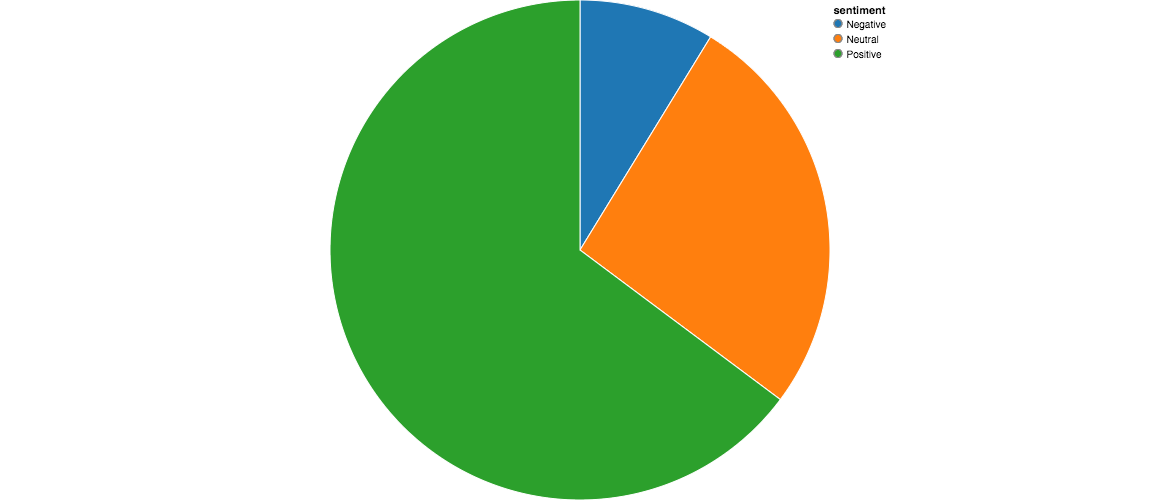

In [13]:
Image('pic/pos-neg.png', width=1650,height=1150)

As expected, most of our instagrams are positive. We also note that there are 3 times more neutral than negative instagrams.

Here are the results of sentiment analysis per month, where each bar represents the proportion of positive-neutral-negative instagrams per month.

#### proportion of instagrams per sentiment and per month

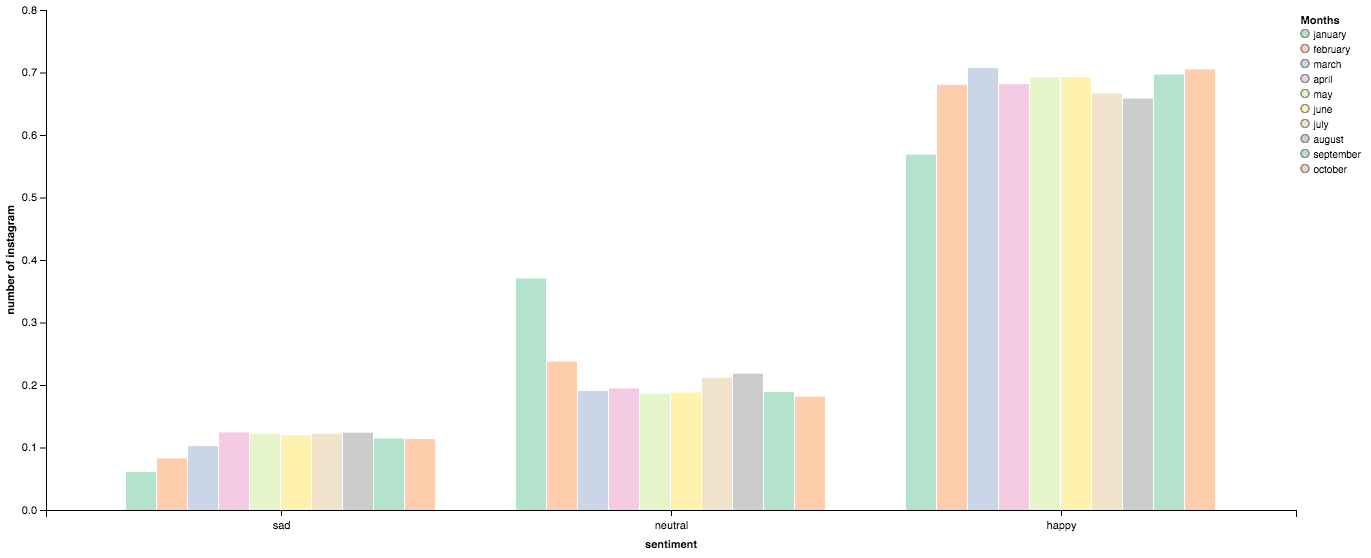

In [15]:
Image('pic/sent_per_month.png', width=1050,height=250)

We are not able to give a complete analysis, because *november* and *december* are missing. At first sight, we have 
approximately the same proportion for each month, with a lower number of happy instas in january, but also a lower of sad instas in the same month, as if people were more neutral at the beggining of the year, giving less expressions in their publication.

Also, if we focus in the last 3 months (*august*, *september*, *october*), we have in proportion a reduction of neutral instas that makes increase the happy ones, whereas neutral stagnate. We can experience here the benefits of the summer break on people's mood.

#### More used tags

Although we did'nt use the tags for the sentiment analysis, we want here to see if we can find happy tags or sad tags, that are always used in happy/sad instagrams. 

## Localisation

We sometimes had access to the exact place of where the photo was taken. But only for *10%* of the dataset. To get around this problem we decided to write an algorithm to localize each instagram posts, based on the hashtags, that often give place information. The main shortcut of our algorithm, is that he will fail when dealing with list of tags with different places mentionned like:

* ` #Geneva #Lausanne #Vaud #Zurich`

or people that mention `#Zurich` when they are in canton de Vaud. We are aware that the following results are not representing the truth because tag lists are not *100%* reliable regarding the localisation, but we will be carefull on our interpretation and conclusion accordingly. We found a location for *2.5 Millions* instagrams among *5.5 millions*. Here are some results.

As you can see on the next histogram, the dataset is inequally distributed among the Switzerland's cantons. The Jura is the less represented with 7 instagrams, whereas the most represented are Genève and Zurich. Note that the y-axis represent take a logarithm in account, so that the differences are huge between Genève with 8.5 millions instas and Saint-Gall (SG) in the middle of the plot with 20.000 instas.

#### Number of instagrams per cantons

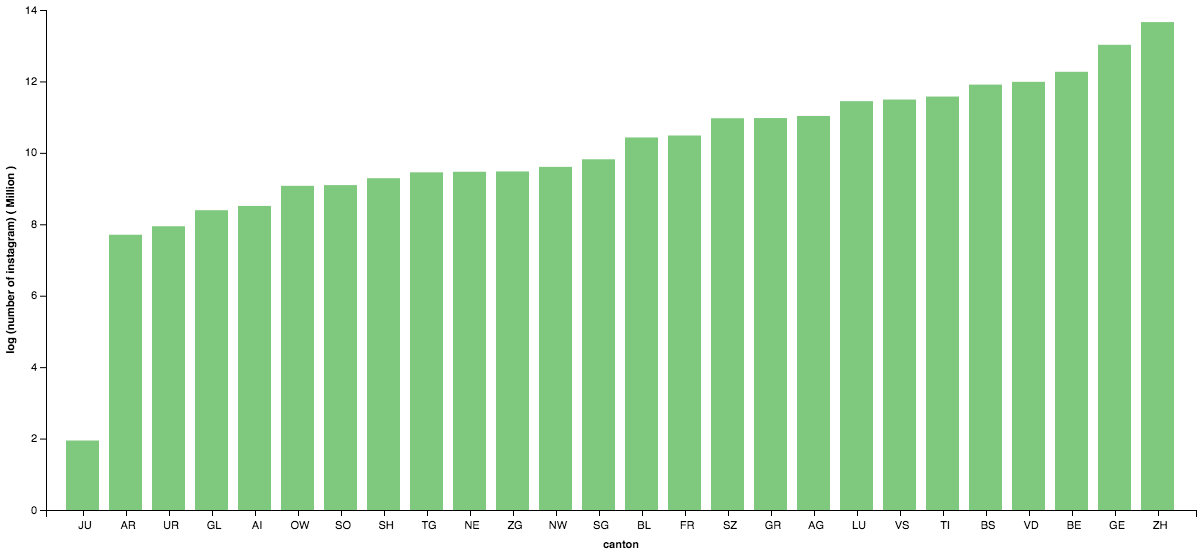

In [16]:
Image('pic/insta_per_canton.png', width=1050,height=250)

The following vizualization is called a *choropleth map*, and give an concrete idea of the location of our instagrams. Not surprisingly, we found more instgrams in cities that in the countryside. Roughly, all instagrams are concentrated around big cities. This map don't give a lot of information but the places where people use instagram and where they don't.

First, there are more population on cities, therefore more instagram users? Furthermore, someone can think that people are more connected when they are in town. We all know that wi-fi connection is better in a city than in moutains.

#### Density of instagrams in Switzerland

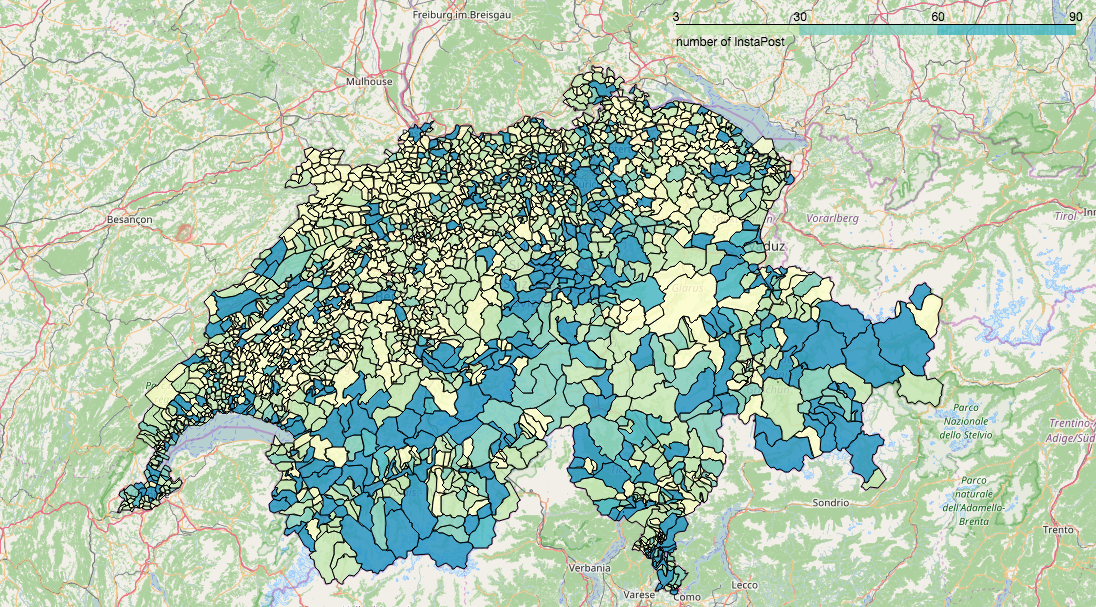

In [3]:
Image('pic/density.png', width=1050,height=250)

In [4]:
vis_city = sqlContext1.read.parquet("viz/insta_density.parquet").toPandas()
geo_path= 'admin_level_8.geojson'
m = folium.Map(location=[46.5, 8], zoom_start=7)
m.choropleth(geo_path=geo_path,
            data=vis_city,
            columns=['city', 'count'],
            key_on='feature.properties.swisstopo:BFS_NUMMER',
            threshold_scale=[0,30,60,90],
            fill_color='YlGnBu',
            fill_opacity=0.8,
            line_opacity=1,
            legend_name='number of InstaPost')
m.save("./density_insta.html")

#m

In the following and last vizualization, we give for each canton a *sentiment score* comprised between 0 and 1. (1 is the happiest)

The score for each canton is a weighted sum of the *happy* and *neutral* instagrams proportions, with coefficient *0.8* and *0.2* respectively.

#### sentiment score by canton

In [39]:
vis_canton = sqlContext1.read.parquet("viz/insta_map_scores.parquet").toPandas()
vis_canton['score'] = vis_canton['happy']/vis_canton['total']*0.7 + vis_canton['neutral']/vis_canton['total']*0.3
for i in range(vis_canton.shape[0]):
    vis_canton.ix[i,0]=vis_canton.ix[i,0][1:]
# find locations for each cantons...
canton_locations=[['Aargau',47.3876664,8.255429499999991],['Appenzell Rhodes-Intérieures ',47.18,9.24],['Appenzell Rhodes-Extérieures ',47.03,9.01],['Bern',46.9479739,7.4474467999999],
                  ['Bâle-Campagne',47.44181220000001,7.764400199999955],['Bâle Ville',47.55959860000001,7.588576099999955],['Fribourg',46.72, 7.09],
                  ['Genève',46.18, 6.13],['Glaris',47.04112319999999,9.067900000000009],['Grison',46.65698709999999,9.578025700000012],
                  ['Jura',47.4,7.0833],['Lucern',47.050168199999,8.3093072000000],['Neuchatel',46.9899874,6.9292732000000],
                  ['Nidwald',46.9267016,8.384998],['Obwald',46.877858,8.25124900],['Saint-Gall',47.4244818,9.376717296],['Schaffhouse',47.43,8.34],
                  ['Soleure',47.2088348,7.5322909999999],['Schwytz',47.0723828,8.79036480000],['Turgau',47.60378559999,9.0557370999999],
                  ['Ticino',46.331734,8.800452899999982], ['Uri',46.7738629,8.60251530000005],['Vaud',46.5, 6.62],['Valais',46.04,7.36],
                  ['Zoug',47.1497017,8.547771499999953], ['Zurich',47.3768866,8.541694000000007]
                 ]
vis_marker0 = sqlContext1.read.parquet("viz/per_canton_month_0.parquet").toPandas()[['canton_date_found','01','02','03','04', '05', '06', '07', '08', '09', '10']]
vis_marker1 = sqlContext1.read.parquet("viz/per_canton_month_1.parquet").toPandas()[['canton_date_found','01','02','03','04', '05', '06', '07', '08', '09', '10']]
vis_marker2 = sqlContext1.read.parquet("viz/per_canton_month_2.parquet").toPandas()[['canton_date_found','01','02','03','04', '05', '06', '07', '08', '09', '10']]
vis_marker2.loc[-1]=[' JU',0,0,0,0,0,0,0,0,0,0]
vis_marker_0=vis_marker0.set_index('canton_date_found').sort_index()
vis_marker_1=vis_marker1.set_index('canton_date_found').sort_index()
vis_marker_2=vis_marker2.set_index('canton_date_found').sort_index()
stacks = []
for i in range(vis_marker0.shape[0]):
    kant=vis_marker_0.index[i]
    listeu0 =vis_marker_0.ix[i,:].tolist()
    listeu1 =vis_marker_1.ix[i,:].tolist()
    listeu2 =vis_marker_2.ix[i,:].tolist()
    
    month_index = ['january','february','march','april', 'may','june','july', 'august','september','october']
    df_chart = pd.DataFrame(index=month_index) 
    df_chart['happy']=listeu0
    df_chart['neutral']=listeu1
    df_chart['sad']=listeu2
    #print(df_chart)
    df_chart_copy=df_chart.copy()
    for j in df_chart.index:
        if(np.sum(df_chart.loc[j])!=0):
            df_chart_copy.loc[j]=df_chart.loc[j]/np.sum(df_chart.loc[j])
    #print(df_chart_copy) 
    stack = vincent.StackedBar(df_chart_copy, width=450, height=150)
    stack.axis_titles(x='months', y='number of insta')
    stack.scales['x'].padding = 0.2
    #stack.width
    stack.colors(brew='Pastel1')
    stack.legend(title='Canton: '+canton_locations[i][0])
    stacks.append(stack)
    # Let Folium determine the scale.
canton_topo = r'ch-cantons.topojson.json'
m = folium.Map(location=[46.55, 6.76], zoom_start=7)
m.choropleth(geo_path=canton_topo,
            data=vis_canton[['canton','score']],
            columns=['canton', 'score'],
            key_on='feature.id',
            threshold_scale=[0.35,0.5,0.53,0.54,0.55,0.56],
            fill_color='PuBu', line_opacity=1,
            
            fill_opacity=0.8,
            legend_name='Sentiment score',
             topojson='objects.cantons')
marker_cluster = folium.MarkerCluster("stats per canton cluster").add_to(m)
j=0
for i in canton_locations:
    popup = folium.Popup(max_width=3800)
    folium.Vega(stacks[j], height=250, width=600).add_to(popup)
    folium.CircleMarker(canton_locations[j][1:],radius=12,popup=popup,color='black',fill_opacity=0.8,fill_color='grey').add_to(marker_cluster)
    j=j+1

In [40]:
m
m.save("./canton_sentiments.html")